In [128]:
import numpy as np
import pandas as pd
import scipy.stats
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
class Leitner:
    def __init__(self, n_item, delay_factor, delay_min):

        box = np.full(n_item, -1)
        due = np.full(n_item, -1)

        self.n_item = n_item

        self.delay_factor = delay_factor
        self.delay_min = delay_min

        self.box = box
        self.due = due

    def update_box_and_due_time(self, last_idx, last_was_success, last_time_reply):

        if last_was_success:
            self.box[last_idx] += 1
        else:
            self.box[last_idx] = max(0, self.box[last_idx] - 1)

        delay = self.delay_factor ** self.box[last_idx]
        # Delay is 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ... minutes
        self.due[last_idx] = last_time_reply + self.delay_min * delay

    def _pickup_item(self, now):

        seen = np.argwhere(np.asarray(self.box) >= 0).flatten()
        n_seen = len(seen)

        if n_seen == self.n_item:
            return np.argmin(self.due)

        else:
            seen__due = np.asarray(self.due)[seen]
            seen__is_due = np.asarray(seen__due) <= now
            if np.sum(seen__is_due):
                seen_and_is_due__due = seen__due[seen__is_due]

                return seen[seen__is_due][np.argmin(seen_and_is_due__due)]
            else:
                return self._pickup_new()

    def _pickup_new(self):
        return np.argmin(self.box)

    def ask(self, now, last_was_success, last_time_reply, idx_last_q):

        if idx_last_q is None:
            item_idx = self._pickup_new()

        else:

            self.update_box_and_due_time(
                last_idx=idx_last_q,
                last_was_success=last_was_success,
                last_time_reply=last_time_reply,
            )
            item_idx = self._pickup_item(now)

        return item_idx

In [3]:
np.random.seed(123)
n_item = 500

ss_n_iter = 100
time_per_iter = 4
n_sec_day = 24 * 60**2
n_ss = 100
eval_ts = n_ss * n_sec_day
review_ts = np.hstack([
        np.arange(x, x + (ss_n_iter * time_per_iter), time_per_iter)
        for x in np.arange(n_sec_day * n_ss, n_sec_day)])

In [33]:
def run(param, agent=0, c=1e-05):
    bkp = []

    n_total_iter = len(review_ts)

    rd = np.log(np.random.random(size=n_total_iter))

    is_it_spec = len(np.asarray(param).shape) > 1

    lei = Leitner(n_item=n_item, delay_min=4, delay_factor=2)

    n_rep = np.full(n_item, -1, dtype=int)
    last_pres = np.zeros(n_item)

    last_item = None
    last_success = None
    last_ts = None

    for i, ts in enumerate(review_ts):

        item = lei.ask(
            now=ts,
            idx_last_q=last_item,
            last_was_success=last_success,
            last_time_reply=last_ts)

        if is_it_spec:
            α, β = param[item, 0], param[item, 1]
        else:
            α, β = param[0], param[1]
            
        delta_rep = ts - last_pres[item]
        n_rep_i = n_rep[item]
        if n_rep_i < 0:
            success = False
        else:
            lp = - α * (1 - β)**n_rep_i * delta_rep * c
            success = lp > rd[i]
            
            # Backup
            bkp.append({
                "agent": agent,
                "item": item, "success": success, 
                "n_rep": n_rep_i, 
                "delta_rep": delta_rep})

        # Update values
        n_rep[item] += 1
        last_pres[item] = ts
        last_success = success
        last_ts = ts
        last_item = item
    return pd.DataFrame(bkp)

In [43]:
df = run([5.0, 0.3])
df

,agent,item,success,n_rep,delta_rep
0,0,0,True,0,4.0
1,0,0,True,1,8.0
2,0,1,True,0,8.0
3,0,1,True,1,8.0
4,0,2,True,0,8.0
...,...,...,...,...,...
9551,0,440,True,2,24.0
9552,0,442,True,1,8.0
9553,0,441,True,2,16.0
9554,0,437,True,7,64.0


In [44]:
df.success.mean()

0.9141900376726664

In [59]:
delta_rep = df.delta_rep.values
n_rep = df.n_rep.values
success = df.success

c = 1e-05

with pm.Model() as model:

    α = pm.HalfFlat('α')  # pm.Bound(pm.Flat, lower=0.02, upper=2500.0) # pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
    β = pm.Bound(pm.Flat, lower=0.0, upper=1.0)('β')  # pm.TruncatedNormal('β', mu=0.1, sigma=0.1, lower=0.0, upper=1.0)

    lp = - delta_rep * α * (1 - β) ** n_rep * c
    logit_p = lp - np.log(1-np.exp(lp) + eps)

    recall = pm.Bernoulli('recall', logit_p=logit_p, observed=success)

In [60]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8826683521393481, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [61]:
trace_sm = az.summary(trace)
trace_sm

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,4.763,0.334,4.174,5.400,0.015,0.011,477.0,469.0,483.0,752.0,1.0
β,0.292,0.006,0.282,0.302,0.000,0.000,475.0,473.0,473.0,564.0,1.0


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

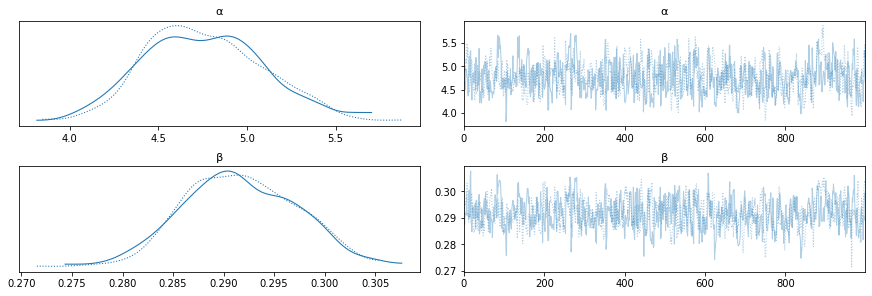

In [62]:
az.plot_trace(trace, var_names=['α', 'β'])

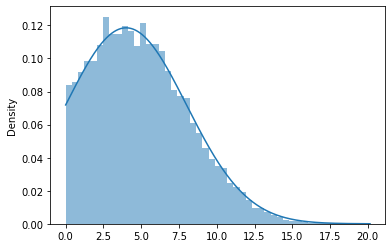

In [129]:
m_alpha = 4
s_alpha = 4
fig, ax = plt.subplots()

a = 0 # 15
b = np.inf # 25 # np.inf

kwargs_alpha = dict(loc=m_alpha, scale=s_alpha, a=(a-m_alpha)/s_alpha, b=(b-m_alpha)/s_alpha)

x = scipy.stats.truncnorm.rvs(size=10000, **kwargs_alpha)
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, np.max(x), 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_alpha)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')

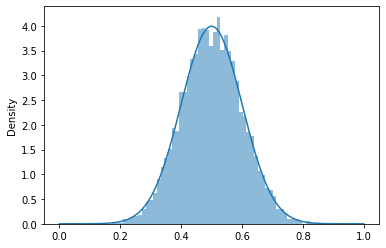

In [130]:
m_beta = 0.5
s_beta = 0.1
fig, ax = plt.subplots()

a = 0 # 15
b = 1 # 25 # np.inf

kwargs_beta = dict(loc=m_beta, scale=s_beta, a=(a-m_beta)/s_beta, b=(b-m_beta)/s_beta)

x = scipy.stats.truncnorm.rvs(size=10000, **kwargs_beta)
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, 1, 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_beta)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')

In [140]:
n = 100
param = np.vstack((scipy.stats.truncnorm.rvs(size=n, **kwargs_alpha), 
                   scipy.stats.truncnorm.rvs(size=n, **kwargs_beta))).T
df_param = pd.DataFrame(param, columns=('α', 'β'))
df_param

,α,β
0,5.195262,0.458774
1,5.695338,0.367789
2,7.547730,0.393697
3,4.202585,0.530609
4,1.221662,0.575450
...,...,...
95,2.673052,0.540908
96,5.840817,0.514956
97,3.872002,0.267964
98,8.629587,0.645134


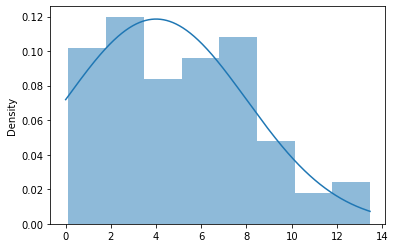

In [141]:
fig, ax = plt.subplots()

x = df_param.α.values
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, np.max(x), 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_alpha)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')

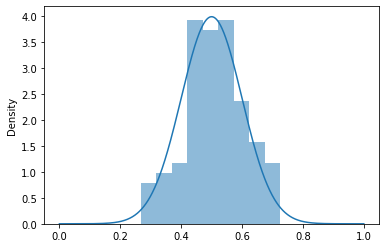

In [143]:
fig, ax = plt.subplots()

x = df_param.β.values
sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
x_th = np.linspace(0, 1, 1000)
y_th = scipy.stats.truncnorm.pdf(x_th, **kwargs_beta)
ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')

In [144]:
r = []
for i, pr in enumerate(param):
    r.append(run(pr, agent=i))

df = pd.concat(r)
df

,agent,item,success,n_rep,delta_rep
0,0,0,True,0,4.0
1,0,0,True,1,8.0
2,0,1,True,0,8.0
3,0,1,True,1,8.0
4,0,2,True,0,8.0
...,...,...,...,...,...
9502,99,485,True,6,72.0
9503,99,490,True,2,28.0
9504,99,487,True,6,64.0
9505,99,491,True,2,20.0


In [145]:
df.groupby("agent")["success"].mean()

agent
0     0.965187
1     0.940818
2     0.939067
3     0.977053
4     0.993789
        ...   
95    0.983158
96    0.969907
97    0.911802
98    0.980421
99    0.966867
Name: success, Length: 100, dtype: float64

In [146]:
eps = np.finfo(float).eps

In [72]:
with pm.Model() as model:
    
    α = pm.HalfFlat('α', shape=n)  # pm.Bound(pm.Flat, lower=0.02, upper=2500.0) # pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
    β = pm.Bound(pm.Flat, lower=0.0, upper=1.0)('β', shape=n) 

    to_concat = []
    
    for i in range(n):
        df_a = df[df.agent == i]
        n_rep, delta_rep = df_a.n_rep.values, df_a.delta_rep.values
        
        alpha = α[i]
        beta = β[i]
        
        lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
        logit_p = lp - np.log(1 - np.exp(lp) + eps)
        
        to_concat.append(logit_p)
    
    logit_p_all = tt.concatenate(to_concat)
    success = df.success.astype(bool).values
    
    recall = pm.Bernoulli('recall', logit_p=logit_p_all, observed=success)

In [74]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 984 seconds.


In [75]:
trace_sm = az.summary(trace)
trace_sm

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],10.581,1.432,8.071,13.377,0.027,0.020,2724.0,2489.0,2900.0,1342.0,1.00
α[1],7.961,1.220,5.887,10.273,0.027,0.020,1979.0,1880.0,2068.0,1318.0,1.00
α[2],6.679,0.980,4.990,8.577,0.019,0.014,2644.0,2548.0,2697.0,1662.0,1.00
α[3],9.133,1.470,6.666,12.077,0.030,0.021,2353.0,2342.0,2288.0,1516.0,1.00
α[4],13.799,3.376,7.954,19.982,0.073,0.055,2158.0,1919.0,2258.0,1557.0,1.00
α[5],5.542,0.980,3.849,7.397,0.019,0.014,2582.0,2455.0,2621.0,1408.0,1.00
α[6],3.307,0.436,2.531,4.126,0.008,0.006,2907.0,2729.0,2997.0,1625.0,1.00
α[7],4.024,0.521,3.114,5.058,0.010,0.007,2590.0,2532.0,2586.0,1594.0,1.00
α[8],6.355,0.918,4.806,8.170,0.020,0.014,2215.0,2131.0,2275.0,1645.0,1.00
α[9],9.354,1.293,7.027,11.878,0.024,0.018,2866.0,2725.0,2918.0,1376.0,1.00


In [147]:
with pm.Model() as model:
    
    mu_a = pm.HalfFlat("mu_a")
    sigma_a = pm.HalfFlat("sigma_a")
    mu_b = pm.Bound(pm.Flat,lower=0, upper=1)("mu_b")
    sigma_b = pm.HalfFlat("sigma_b")
    
    α = pm.TruncatedNormal('α', mu=mu_a, sigma=sigma_a, lower=0.0, shape=n)
    β = pm.TruncatedNormal('β', mu=mu_b, sigma=sigma_b, lower=0.0, upper=1.0, shape=n)
    
    to_concat = []
    
    for i in range(n):
        df_a = df[df.agent == i]
        n_rep, delta_rep = df_a.n_rep.values, df_a.delta_rep.values
        
        alpha = α[i]
        beta = β[i]
        
        lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
        logit_p = lp - np.log(1 - np.exp(lp) + eps)
        
        to_concat.append(logit_p)

#     lp = - delta_rep * alpha * (1 - beta) ** n_rep * 1e-05
#     logit_p = lp - np.log(1 - np.exp(lp) + eps)
    # logit_p = alpha / pm.math.maximum(alpha)
    
    
    logit_p_all = tt.concatenate(to_concat)
    success = df.success.astype(bool).values
    
    recall = pm.Bernoulli('recall', logit_p=logit_p_all, observed=success)

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8148 seconds.


In [ ]:
trace_sm = az.summary(trace)
trace_sm

In [ ]:
az.plot_posterior(trace, var_names=['mu_a', 'mu_b', 'sigma_a', 'sigma_b'])

In [89]:
# for i in range(n):
    
#     df_a = df[df.agent == i]
#     n_rep, delta_rep, success = df_a.n_rep.values, df_a.delta_rep.values, df_a.success.astype(bool).values
#     eps = np.finfo(float).eps
    
#     with pm.Model() as model:

#         α = pm.TruncatedNormal('α', mu=2.0, sigma=1.0, lower=0.02, upper=2500.0)
#         β = pm.TruncatedNormal('β', mu=0.1, sigma=0.1, lower=0.0, upper=1.0)

#         lp = - delta_rep * α * (1 - β) ** n_rep * 1e-05
#         logit_p = lp - np.log(1-np.exp(lp) + eps)

#         recall = pm.Bernoulli('recall', logit_p=logit_p, observed=success)

#     with model:
#         trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)
#     trace_sm = az.summary(trace)
#     print(trace_sm.loc['α', 'mean'], param[i, 0])
#     print(trace_sm.loc['β', 'mean'], param[i, 1])

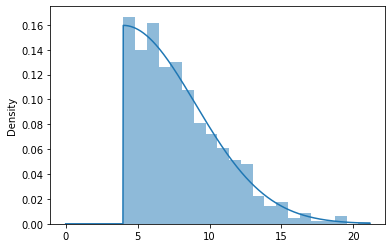

In [100]:
# m = 4
# sig = 5
# fig, ax = plt.subplots()
# x = scipy.stats.halfnorm.rvs(loc=m, scale=sig, size=1000)
# sns.histplot(x, alpha=0.5, linewidth=0, stat="density", ax=ax, color='C0')
# x_th = np.linspace(0, np.max(x), 1000)
# y_th = scipy.stats.halfnorm.pdf(x_th, loc=m, scale=sig)
# ax.plot(x_th, y_th, color='C0', label="theoretical distribution", ls='-')